# Introduction

Some city planning documents are structured and well-organized, while others are written in paragraph format without clear headings.

As discussed previously, structured documents with a clear pattern are suited for direct extraction techniques.

But what about unstructured plans, which often have policies embedded within paragraphs?


**Large Language Models (LLM’s)** like ChatGPT, Gemini, and Copilot are capable of analyzing and interpreting natural language across most document structures. Our approach involves writing custom queries (instructions) to ask the Gemini API to extract actionable policies from a given document. We will demonstrate how to prepare the document for processing and write queries to pull relevant policies.

# Overview

This process involves 5 key steps:


1. Extract all text from the document, page-by-page

2. Set up Gemini’s Generative Model (the LLM we are asking questions to)

3. Write the query

4. Run the model

5. Save extracted policies to a CSV file

# Setup

Before we dive into an example, here are instructions to set up the Gemini API!

### __Retrieve API Key__

      Why do I need an API key?

      An API key is like an access badge that allows you to connect to the Gemini system.
      
      Do not expose your API key by sharing it with people outside
      of your team, or by saving it as a comment in your code!!

      Since most APIs are limited-use and offer paid plans,
      the API key tracks how much you’ve used the service for a given project.


You will need an API key to run the Gemini LLM for this example.

To retrieve the key, please login with the username and password provided to you:

https://api-key-fire-server.onrender.com

Once you’ve copied the API key, please run the code below and paste it when prompted:


In [ ]:
import getpass

api_key = getpass.getpass("Paste the API key here and press enter (it will be hidden): ")

Paste the API key here and press enter (it will be hidden): ··········


### **Rate Limits**

**Gemini's free tier limits the number of requests you can send per minute.**

These *rate limits* are measured in 3 ways:

1.   Requests per minute (**RPM**)
2.   Requests per day (**RPD**)
3.   Tokens per minute (**TPM**)


**1 request** = 1 query / prompt sent to the Gemini LLM

**1 token** ~ 4 characters

*Special characters may count for more tokens.

*Typically, 100 tokens = 60-80 English words.

---


More on tokens: https://ai.google.dev/gemini-api/docs/tokens?lang=python

More on rate limits: https://ai.google.dev/gemini-api/docs/rate-limits



# Step-by-Step Tutorial

Consider __Atascadero's Community Wildfire Protection Plan__
 (CWPP):

https://docs.google.com/document/d/1sQ4jH-Z3VCh-tZ72l5WQZPFRxxp3Cw1E/edit?usp=sharing&ouid=114051710965014109683&rtpof=true&sd=true

### 1. Analyze Document Structure

The Atascadero CWPP is 25 pages long with 4 main sections:

1. City overview
2. Collaboration with agencies
3. Values
4. Plan recommendations / goals

As you scroll through, note how most policies can be found in tables within **Section IV: Plan Recommendations and Goals** (p. 17-25).

These are easy to find if we find all tables with the same header and format.
However, issues arise when we read through the Fire Environment Section (p.8).


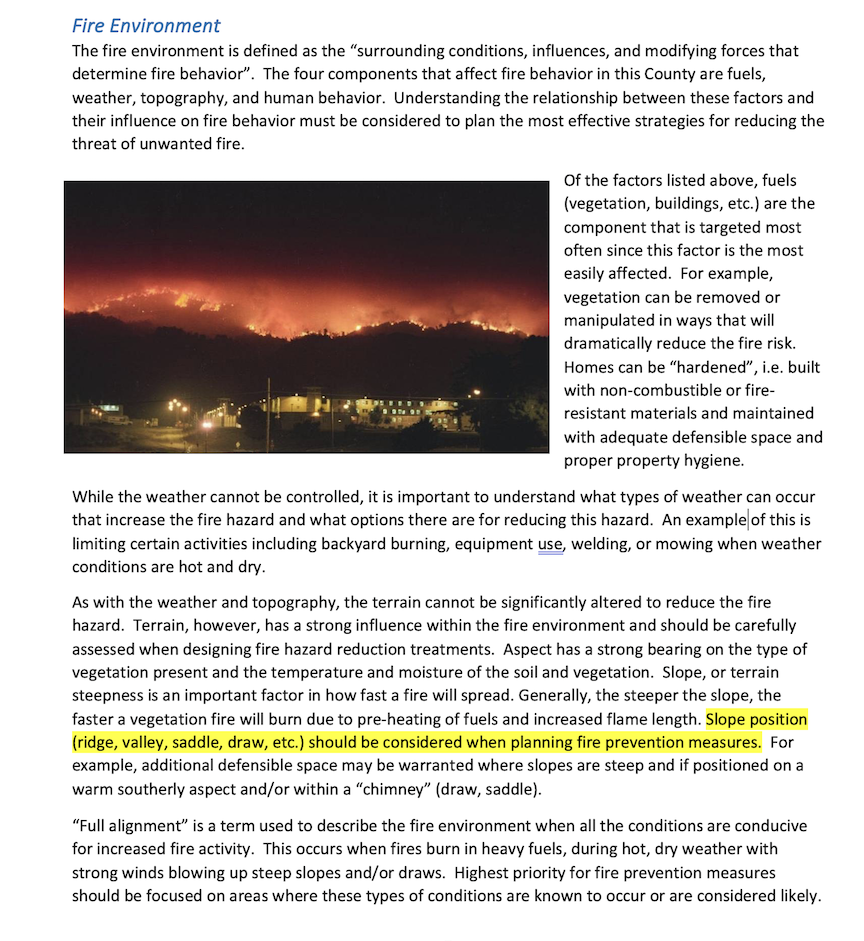

The text highlighted above is an **implicit policy** because isn’t labelled as a goal / measure, but describes actions that can be taken to prevent wildfires (considering slope position).

We may still want to extract this text since it contains useful information on fire prevention strategies.


Before you decide whether to use direct extraction or an LLM, scan through sections where you’d expect to find policies and pay attention to large chunks of text. You might find several policy-like statements embedded within paragraphs;  direct extraction methods would fail to capture these.


### 2. Prepare document for text extraction

Define document's file path:


In [ ]:
# Napa Hazard Plan Link: https://drive.google.com/file/d/1uwfq7JZkkrbzZQlsCwbHSNAHE3VFRUB8/view?usp=sharing

file_id = '1uwfq7JZkkrbzZQlsCwbHSNAHE3VFRUB8'  # Google Drive File ID
url = f'https://drive.google.com/uc?export=download&id={file_id}'

In [ ]:
# Reading in a .docx file, so use the .docx library
# If you're running this for the first time, uncomment the lines below to install packages before importing libraries
!pip install python-docx
!pip install requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 11.8 MB/s eta 0:00:00


In [ ]:
import docx
import requests
import io

In [ ]:
# Fetch publicly shared file from Google Drive, load into memory

def fetch_docx_from_drive(file_id):
    url = f'https://drive.google.com/uc?export=download&id={file_id}'
    response = requests.get(url)
    response.raise_for_status()  # Ensure successful request

    # Use io.BytesIO to read file content into memory
    file_stream = io.BytesIO(response.content)

    return file_stream

# Fetch file, load it into memory
file_stream = fetch_docx_from_drive(file_id)

Extract text from document, line-by-line:

In [ ]:
def extract_text_from_docx(docx_path):
    lines = [] # Define a list to store lines of text in

    doc = docx.Document(docx_path)  # Read in doc from file path (docx_path)

    for paragraph in doc.paragraphs:
        for line in paragraph.text.split("\n"): # Split paragraphs into lines by new lines (denoted by /n)
            clean_line = line.strip()   # Strip extra whitespace from line

            if clean_line: # If line is non-empty, add to list of lines
                lines.append(clean_line)

    return lines

lines = extract_text_from_docx(file_stream)

In [ ]:
# Print out first 5 lines (change 5 to another number n to display n lines)
lines[:5]

# Print out the 6th line (index starts at 0 so index = 5 means 6th line)
# lines[5]

['ACKNOWELDGEMENTS',
 'This Community Wildfire Protection Plan is a guide to provide a community that is prepared and resilient to the impacts of wildland urban interface fires.',
 'Thank you to the San Luis Obispo County Fire for their assistance in preparing this document.',
 'Thank you to the City of Atascadero Technology Department for assisting with statistics and GIS mapping for the plan.',
 'A special thank you to the San Luis Obispo County Fire Safe Council (SLO FSC) for securing funding and coordinating development of this plan.']

Extract tables from document (majority of policies are here):

In [ ]:
def extract_table_from_docx(docx_path):

    tables = [] # Define a list to store tables in

    doc = docx.Document(docx_path)  # Read in doc from file path (docx_path)

    for table in doc.tables:

        # Extract a single table
        table_data = []
        for row in table.rows: # Extract rows from the table
            row_data = [cell.text.strip() for cell in row.cells]
            table_data.append(row_data)

        tables.append({"table": table_data})    # Add table to list of tables

    return tables

tables = extract_table_from_docx(file_stream)

In [ ]:
# Print out first 3 tables (change 3 to another number n to display n tables)
tables[:3]

# Print out 6th table (index starts at 0 so index = 5 means 6th element)
#tables[5]

[{'table': [['Severity Zone Rating',
    'Acres',
    'Number of Parcels',
    'Number of Homes'],
   ['Very High Fire Severity Zone', '329', '53', '39'],
   ['High Fire Severity Zone', '10388', '5132', '5960'],
   ['Moderate Fire Severity Zone', '4632', '5945', '5771']]},
 {'table': [['Description', 'Acres', 'Percent'],
   ['Agriculture', '823', '4.9%'],
   ['Annual Grass', '2845', '17.0%'],
   ['Barren', '129', '0.8%'],
   ['Blue Oak Pine', '52', '0.3%'],
   ['Blue Oak Woodland', '1243', '7.4%'],
   ['Coastal Oak Woodland', '4496', '26.9%'],
   ['Lawn', '232', '1.4%'],
   ['Mixed Hardwood', '2', '0.0%'],
   ['Orchard', '77', '0.5%'],
   ['Road', '1472', '8.8%'],
   ['Shrub', '693', '4.1%'],
   ['Exotic Urban Trees', '1726', '10.3%'],
   ['Urban', '1158', '6.9%'],
   ['Valley Oak Woodland', '1120', '6.7%'],
   ['Riparian Woodland', '617', '3.7%'],
   ['Water', '53', '0.3%']]},
 {'table': [['Strategic Policy',
    'Benefits of the Project to the Community',
    'Category',
    'Timelin

### 3. Count Tokens for Rate Limit

**The Gemini 2.0 Flash model has the following rate limits:**



*   15 requests / minute (RPM)
*   1,000,000 tokens / minute (TPM)
*   1,500 requests / day (RPD)







Let's roughly estimate the rate limits for querying Gemini using the CWPP:



15 requests / minute

*   We have 60 seconds and a maximum of 15 requests to make in that time frame
*   60 / 15 = minimum of a 4 second delay between each request

Safer to have a longer delay, so we'll wait **6 seconds** between each query.



**What about tokens?**

We can run code on the lines extracted previously (stored in the variable *lines*) to check if any exceed the token limit.

Note that for the Gemini 2.0 Flash model, the token limit is 8192 per request (question + prompt).

In [ ]:
from google import genai

client = genai.Client(api_key=api_key)

max_tokens = 0    # variable to keep track of the maximum token count encountered within a line of text
max_line_index = -1   # index to keep track of which line had the highest token count
TOKEN_LIMIT = 8192  # Gemini 2.0 Flash token limit

for i, line_text in enumerate(lines):   # Loop through each line, retrieve line index i and line_text
    token_data = client.models.count_tokens(
        model="gemini-2.0-flash", contents=line_text
    )
    total_tokens = token_data.total_tokens    # Get total tokens
    if total_tokens > max_tokens:
        max_tokens = total_tokens     # Update max_tokens
        max_line_index = i            # Store index of line with max tokens

print(f"Line {max_line_index + 1} has the maximum tokens: {max_tokens}")

if max_tokens > TOKEN_LIMIT:    # Print warning if line with max tokens exceeds token limit
    print(f"⚠️ Warning: Line {max_line_index + 1} exceeds the token limit of {TOKEN_LIMIT} tokens.")


Line 31 has the maximum tokens: 228


228 is far below the maximum token limit of 8192 / request, so we're ready to proceed!

If any of these lines exceed the token limit, you will need to go back and split the document into smaller chunks.

Learn more about token counting with Gemini here: https://ai.google.dev/gemini-api/docs/tokens?lang=python

### 4. Configure Gemini LLM

Load API key

In [ ]:
# Uncomment line below if running for first time
#!pip install google-generativeai
import google.generativeai as genai

In [ ]:
genai.configure(api_key=api_key) # load in API key

Set up Gemini Model

In [ ]:
def query_gemini(prompt):

    try:    # Try building the model
        model = genai.GenerativeModel(model_name="gemini-2.0-flash")
        response = model.generate_content(prompt)   # Store response from prompt sent to LLM

        return response.text    # Return text response

    except Exception as e:   # If build fails, print error
        print(f"Error: {str(e)}")
        return f"Error processing text/table"

    In the code above, we are using the Gemini 2.0 Flash model.
    Feel free to change the model_name if you'd like to test other models.

    Currently, Gemini 2.0 Flash is the newest model, but older models are
    better suited for different use cases.

    Models marked with 'preview' have stricter rate limits - this means you must send fewer requests (queries) per minute to the LLM.

  Check out all available models here: https://ai.google.dev/gemini-api/docs/models

### 5. Run the Model / Extract Policies

Ask Gemini LLM to extract policies from all document lines

In [ ]:
import time

In [ ]:
def process_lines(lines):

    extracted_policies = []

    # Loop through each line in document
    # 1 query per line
    for i, line in enumerate(lines):
        # Uncomment line below to check if each line is processing correctly
        # print(f"Processing line {i+1}...")

        # Write the prompt
        text_prompt = f"Extract both explicit and implicit policies from this text. A policy can be a rule, guideline, or a recommended action. Provide the exact wording:\n\n{line}"

        # Store response and save it to list of extracted policies
        response = query_gemini(text_prompt)
        extracted_policies.append(f"Line {i+1}:\n{response}\n")

        if i < len(lines) - 1:  # Avoid waiting after last line
            time.sleep(4)  # Wait 6 seconds before next request to stay within rate limit

    return extracted_policies

    When writing a prompt, make it as specific and clear as possible.

    Note how we asked to extract both implicit and explicit policies.

    Define what counts as a policy
    Ask for the exact wording so the LLM does not paraphrase policies.

Ask Gemini LLM to extract policies from all tables

In [ ]:
def process_tables(tables):

    extracted_policies = []

    # Loop through each line in document
    # 1 query per table
    for i, table in enumerate(tables):
        print(f"Processing table {i+1}...")

        # Write the prompt
        table_prompt = f"Extract any policies found in the following table if there are any. Provide the exact wording:\n\n{table}"

        # Store response and save it to list of extracted policies
        response = query_gemini(table_prompt)
        extracted_policies.append(f"Table {i+1}:\n{response}\n")

        if i < len(tables) - 1:  # Avoid waiting after last line
            time.sleep(6)  # Wait 6 seconds before next request to stay within rate limit

    return extracted_policies

Run methods to get policies from lines (expected runtime ~20 minutes)

In [ ]:
extracted_policies_lines = process_lines(lines)

# Print out first 5 elements
extracted_policies_lines[:5]

Error: HTTPConnectionPool(host='localhost', port=43885): Read timed out. (read timeout=600.0)
Error: HTTPConnectionPool(host='localhost', port=43885): Read timed out. (read timeout=600.0)
Error: HTTPConnectionPool(host='localhost', port=43885): Read timed out. (read timeout=600.0)
Error: HTTPConnectionPool(host='localhost', port=43885): Read timed out. (read timeout=600.0)
Error: HTTPConnectionPool(host='localhost', port=43885): Read timed out. (read timeout=600.0)
Error: HTTPConnectionPool(host='localhost', port=43885): Read timed out. (read timeout=600.0)
Error: HTTPConnectionPool(host='localhost', port=43885): Read timed out. (read timeout=600.0)
Error: HTTPConnectionPool(host='localhost', port=43885): Read timed out. (read timeout=600.0)
Error: HTTPConnectionPool(host='localhost', port=43885): Read timed out. (read timeout=600.0)
Error: HTTPConnectionPool(host='localhost', port=43885): Read timed out. (read timeout=600.0)
Error: HTTPConnectionPool(host='localhost', port=43885): Rea

Run methods to get policies from tables

In [ ]:
extracted_policies_tables = process_tables(tables)

# Print out first 3 elements
extracted_policies_tables[:3]

### 6. Save Policies to CSV

Save all policies to csv files

In [ ]:
import pandas as pd

In [ ]:
# 2 columns: Line, Policy Extracted for that line
lines_df = pd.DataFrame({"Lines": lines, "Extracted Policies": extracted_policies_lines})
lines_df.to_csv("text_policies_comparison.csv", index=False)  # For CSV

print("Spreadsheet saved successfully!")

In [ ]:
# Save table, extracted policies from table

flattened_tables = ["\n".join([" | ".join(row) for row in table_dict['table']]) for table_dict in tables]
tables_df = pd.DataFrame({"Tables": flattened_tables, "Extracted Policies": extracted_policies_tables})
tables_df.to_csv("table_policies_comparison.csv", index=False)

print("Spreadsheet saved successfully!")